<div style="text-align: center; background-color: #856ff8; padding: 10px;">
    <h2 style="font-weight: bold;">OUTLINE</h2>
</div>

- Importing Various Modules
- Loading Dataset
- Training, Development and Testing Phase
- Feature Extraction Using TD-IDF
  - Unigram
  - Bigram
  - Trigram
- Data Modeling

<div style="text-align: center; background-color: yellow; padding: 10px;">
    <h2 style="font-weight: bold;">IMPORTING VARIOUS MODULES</h2>
</div>

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from time import time

from textblob import TextBlob

from sklearn.feature_extraction import text

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn.feature_selection import SelectFromModel

import warnings
warnings.filterwarnings("ignore")

<div style="text-align: center; background-color: yellow; padding: 10px;">
    <h2 style="font-weight: bold;">LOADING DATASET</h2>
</div>

In [2]:
# Reading the dataset with no columns titles and with latin encoding 
twitter_data = pd.read_csv('twitter_sentiment_data_cleaned.csv', encoding = "ISO-8859-1")

In [3]:
# As the data has no column titles, we will add our own
twitter_data.columns = ['sentiment', 'text']

In [4]:
# Show the first 5 rows of the dataframe.
twitter_data.head().style.set_properties(**{'background-color': '#E9F6E2','color': 'black','border-color': '#8b8c8c'})

,sentiment,text
0,4,is lookin ward to a long weekend really dont want to go to work day tho x
1,4,myweakness is music and i live to meet the people who make it
2,4,figured out the internet on my new ipod
3,4,can not wait to worship with you guys tonight it ll be so much fun
4,4,congrats james i m sure the book is going to be a huge success


In [5]:
# Print bottom 5 rows in the dataframe.
twitter_data.tail().style.set_properties(**{'background-color': '#E9F6E2','color': 'black','border-color': '#8b8c8c'})

,sentiment,text
399995,0,that is he does not know i tweet and i would like keep it that way sorry bad wife
399996,0,huh what
399997,0,only thing is im broke
399998,0,wish i could work from home today nothing will be going on here
399999,0,i miss you too i was so worried well today s my last day of school b the break glad u feel better love you


In [6]:
# Print the shape of the DataFrame
print("The shape of data frame:", twitter_data.shape)
# Print the length (number of rows) of the DataFrame
print("Number of Rows in the dataframe:", len(twitter_data))
# Print the number of columns in the DataFrame
print("Number of Columns in the dataframe:", len(twitter_data.columns))

The shape of data frame: (400000, 2)
Number of Rows in the dataframe: 400000
Number of Columns in the dataframe: 2


In [7]:
twitter_data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400000 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  400000 non-null  int64 
 1   text       399187 non-null  object
dtypes: int64(1), object(1)
memory usage: 6.1+ MB


In [8]:
twitter_data['sentiment'] = twitter_data['sentiment'].map({0:0,4:1})

In [9]:
twitter_data.dropna(inplace=True)

In [10]:
twitter_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 399187 entries, 0 to 399999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  399187 non-null  int64 
 1   text       399187 non-null  object
dtypes: int64(1), object(1)
memory usage: 9.1+ MB


<div style="text-align: center; background-color: yellow; padding: 10px;">
    <h2 style="font-weight: bold;">TRAINING, DEVELOPMENT AND TESTING PHASE</h2>
</div>

We will split the data into three sections: train, development and test. Our chosen ratio is 98/1/1 i.e. 98% for the training set, 1% for the development set and 1% for the testing set.
* Train set: The dataset used for learning
* Development Set: A validation/development dataset is a sample of data held back from training your model that is used to give an estimate of model skill while tuning model’s hyperparameters.
* Test Set: The dataset used to assess the performance of a model.

In [11]:
# Define all other columns except the target variable
x = twitter_data['text'] 
# Define the target variable
y = twitter_data['sentiment']

In [12]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size = 0.02, random_state = 42)

In [13]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, 
                                                              test_size = 0.5, random_state = 42)

<div style="text-align: center; background-color: yellow; padding: 10px;">
    <h2 style="font-weight: bold;">FEATURE EXTRACTION USING TF-IDF</h2>
</div>

**Term Frequency** measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length or the total number of terms in the document as a way of normalization: 

$$TF(t) = \frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}$$

**Inverse Document Frequency** measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

$$IDF(t) = \log_e{\frac{\text{Total number of documents}} {\text{Number of documents with term t in it}}}$$

Combining these two, we get TF-IDF.

$$TF-IDF(t) = {TF(t)}\times{IDF(t)}$$

The higher the TFIDF score, the rarer the term and vice versa.

In [14]:
null_accuracy = 0
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test==0])/len(x_test)>0.5:
        null_accuracy = len(x_test[y_test==0])/len(x_test)
    else:
        null_accuracy = 1 - len(x_test[y_test==0])/len(x_test)
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("Null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("Accuracy: {0:.2f}%".format(accuracy*100))
    if accuracy>null_accuracy:
        print("Model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy==null_accuracy:
        print("Model has the same accuracy as null accuracy")
    else:
        print("Model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("Train and test time: {0:.2f}s".format(train_test_time))
    print("-"*50)
    return accuracy, train_test_time

In [15]:
tfidf = TfidfVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000, 100001, 10000)   

In [16]:
def nfeature_accuracy_checker(vectorizer = tfidf, n_features = n_features, stop_words = None, 
                              ngram_range = (1,1), classifier = lr):
    result = []
    print(classifier, "\n")
    for n in n_features:
        vectorizer.set_params(stop_words = stop_words, max_features = n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', classifier)])
        print("Validation result for {0} features".format(n))
        nfeature_accuracy, ttime = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, nfeature_accuracy, ttime))
    return result

<br>
<span style="color: yellow; background-color: black; font-weight: bold; padding: 5px; font-size: 32px;"> UNIGRAM </span>
</br>

In [17]:
%%time
print("RESULT FOR UNIGRAM\n")
feature_result_ug_t = nfeature_accuracy_checker()

RESULT FOR UNIGRAM

LogisticRegression() 

Validation result for 10000 features
Null accuracy: 51.13%
Accuracy: 79.16%
Model is 28.03% more accurate than null accuracy
Train and test time: 63.39s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 51.13%
Accuracy: 79.01%
Model is 27.88% more accurate than null accuracy
Train and test time: 68.00s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 51.13%
Accuracy: 79.18%
Model is 28.06% more accurate than null accuracy
Train and test time: 57.31s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 51.13%
Accuracy: 79.56%
Model is 28.43% more accurate than null accuracy
Train and test time: 51.89s
--------------------------------------------------
Validation result for 50000 features
Null accuracy: 51.13%
Accuracy: 79.31%
Model is 28.18% more accurate than null accuracy
Train and test t

<br>
<span style="color: yellow; background-color: black; font-weight: bold; padding: 5px; font-size: 32px;"> BIGRAM </span>
</br>

In [18]:
%%time
print("RESULT FOR BIGRAM\n")
feature_result_bg_t = nfeature_accuracy_checker(ngram_range=(1,2))

RESULT FOR BIGRAM

LogisticRegression() 

Validation result for 10000 features
Null accuracy: 51.13%
Accuracy: 79.78%
Model is 28.66% more accurate than null accuracy
Train and test time: 80.31s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 51.13%
Accuracy: 80.44%
Model is 29.31% more accurate than null accuracy
Train and test time: 81.95s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 51.13%
Accuracy: 80.56%
Model is 29.43% more accurate than null accuracy
Train and test time: 83.76s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 51.13%
Accuracy: 80.96%
Model is 29.83% more accurate than null accuracy
Train and test time: 83.12s
--------------------------------------------------
Validation result for 50000 features
Null accuracy: 51.13%
Accuracy: 81.01%
Model is 29.88% more accurate than null accuracy
Train and test ti

<br>
<span style="color: yellow; background-color: black; font-weight: bold; padding: 5px; font-size: 32px;"> TRIGRAM </span>
</br>

In [19]:
%%time
print("RESULT FOR TRIGRAM\n")
feature_result_tg_t = nfeature_accuracy_checker(ngram_range=(1,3))

RESULT FOR TRIGRAM

LogisticRegression() 

Validation result for 10000 features
Null accuracy: 51.13%
Accuracy: 80.16%
Model is 29.03% more accurate than null accuracy
Train and test time: 40.61s
--------------------------------------------------
Validation result for 20000 features
Null accuracy: 51.13%
Accuracy: 80.71%
Model is 29.58% more accurate than null accuracy
Train and test time: 40.05s
--------------------------------------------------
Validation result for 30000 features
Null accuracy: 51.13%
Accuracy: 80.59%
Model is 29.46% more accurate than null accuracy
Train and test time: 41.18s
--------------------------------------------------
Validation result for 40000 features
Null accuracy: 51.13%
Accuracy: 80.89%
Model is 29.76% more accurate than null accuracy
Train and test time: 40.01s
--------------------------------------------------
Validation result for 50000 features
Null accuracy: 51.13%
Accuracy: 81.06%
Model is 29.93% more accurate than null accuracy
Train and test t

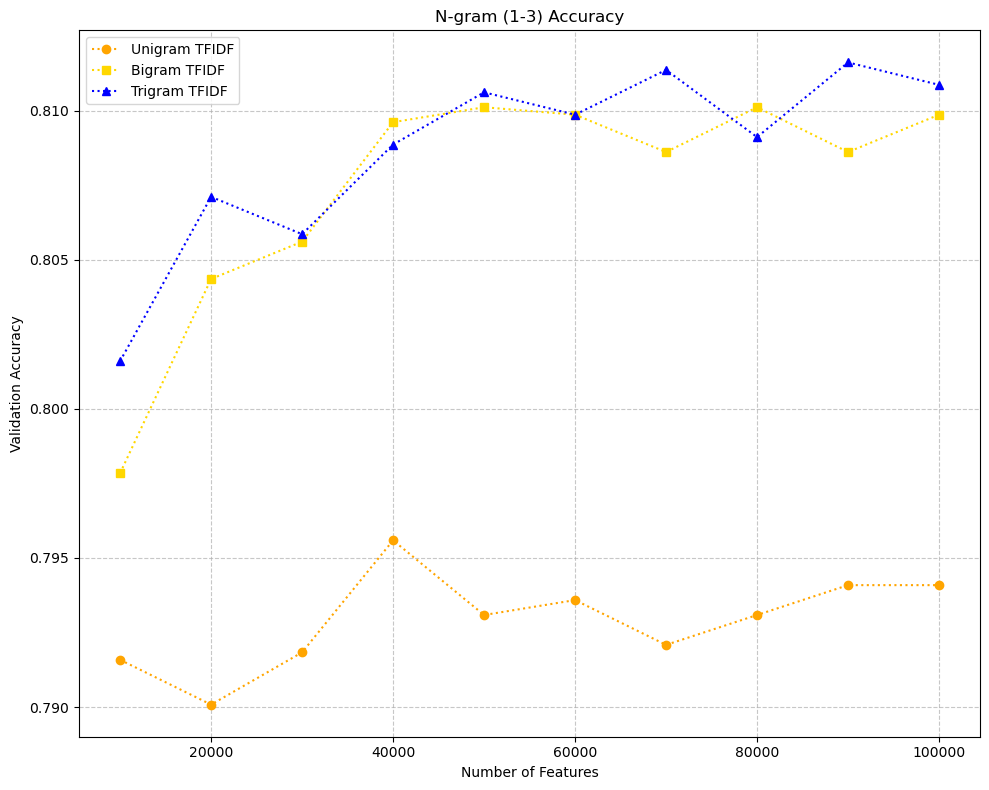

In [20]:
feature_plot_ug_t = pd.DataFrame(feature_result_ug_t, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_bg_t = pd.DataFrame(feature_result_bg_t, columns=['nfeatures', 'validation_accuracy', 'train_test_time'])
feature_plot_tg_t = pd.DataFrame(feature_result_tg_t, columns = ['nfeatures', 'validation_accuracy', 'train_test_time'])

plt.figure(figsize=(10, 8))

# Plotting Unigram TFIDF
plt.plot(feature_plot_ug_t.nfeatures, feature_plot_ug_t.validation_accuracy, label='Unigram TFIDF', color='orange', marker='o', linestyle=':')

# Plotting Bigram TFIDF
plt.plot(feature_plot_bg_t.nfeatures, feature_plot_bg_t.validation_accuracy, label='Bigram TFIDF', color='gold', marker='s', linestyle=':')

# Plotting Trigram TFIDF
plt.plot(feature_plot_tg_t.nfeatures, feature_plot_tg_t.validation_accuracy, label='Trigram TFIDF', color='blue', marker='^', linestyle=':')

# Adding labels and title
plt.title('N-gram (1-3) Accuracy')
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')

# Adding grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Adding legend
plt.legend()

# Adding a tight layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

For bigram and trigram, TfidfVectorizer gives better performance than CountVectorizer.

Bigram TfidfVectorizer at 90000 features gives the highest validation accuracy at 82.45%.

<div style="text-align: center; background-color: yellow; padding: 10px;">
    <h2 style="font-weight: bold;">DATA MODELING</h2>
</div>

In [21]:
names = ['Ridge Classifier', 'Logistic Regression', 'Stochastic Gradient Descent', 'Multinomial NB', 'Bernoulli NB']
classifiers = [
    RidgeClassifier(),
    LogisticRegression(),
    SGDClassifier(),
    MultinomialNB(),
    BernoulliNB(),
]

In [22]:
zipped_clf = zip(names, classifiers)
tfidf = TfidfVectorizer()

In [24]:
def classifier_comparator(vectorizer = tfidf, n_features=10000, stop_words=None, ngram_range=(1,1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range, max_features=n_features)
    for n, c in classifier:
        pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', c)])
        print('Validation result for {}'.format(n), c)
        clf_accuracy, ttime = accuracy_summary(pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n, clf_accuracy, ttime))
    return result

In [25]:
bigram_comparison = classifier_comparator(n_features=90000, ngram_range=(1,2))

Validation result for Ridge Classifier RidgeClassifier()
Null accuracy: 51.13%
Accuracy: 80.01%
Model is 28.88% more accurate than null accuracy
Train and test time: 21.72s
--------------------------------------------------
Validation result for Logistic Regression LogisticRegression()
Null accuracy: 51.13%
Accuracy: 80.86%
Model is 29.73% more accurate than null accuracy
Train and test time: 25.98s
--------------------------------------------------
Validation result for Stochastic Gradient Descent SGDClassifier()
Null accuracy: 51.13%
Accuracy: 78.43%
Model is 27.30% more accurate than null accuracy
Train and test time: 18.30s
--------------------------------------------------
Validation result for Multinomial NB MultinomialNB()
Null accuracy: 51.13%
Accuracy: 78.86%
Model is 27.73% more accurate than null accuracy
Train and test time: 17.48s
--------------------------------------------------
Validation result for Bernoulli NB BernoulliNB()
Null accuracy: 51.13%
Accuracy: 78.83%
Model

In [26]:
labels = ['Classifier', 'Accuracy', 'Time']
df = pd.DataFrame(bigram_comparison, columns = labels)

In [27]:
df.sort_values(by='Accuracy', ascending=False).style.set_properties(**{'background-color': '#E9F6E2','color': 'black','border-color': '#8b8c8c'})

,Classifier,Accuracy,Time
1,Logistic Regression,0.808617,25.984384
0,Ridge Classifier,0.800100,21.721810
3,Multinomial NB,0.788577,17.478353
4,Bernoulli NB,0.788327,18.538436
2,Stochastic Gradient Descent,0.784319,18.296294
